In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Set up display

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# Deep Q-Network

In [3]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        # PyTorch refers to fully connected layers as linear layers
        # The first linear layer takes in the images as input and has 24 outputs
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        # The second linear layer has 24 inputs and 32 outputs
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        # The third linear layer has 32 inputs and 2 outputs
        self.out = nn.Linear(in_features=32, out_features=2)
        # Our only available actions is to move left or move right, hence only
        # two output features: one for each action
        
    def forward(self, t):
        # 't' is an image tensor
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t
        

# Experience Class

In [4]:
# namedtuple() is a Python function for creating tuples with named fields
Experience = namedtuple(
    'Experience', 
    ('state', 'action', 'next_state','reward')
)

# Replay Memory

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count +=1
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

# Epsilon Greedy Strategy

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

# Reinforcement Learning Agent

In [7]:
class Agent():
    # Agent requires a device for tensor calculations ie; a CPU or a GPU
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step +=1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device) # explore
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) # exploit
            

# Environment Manager

In [8]:
class CartPoleEnvManager():
    def __init__(self, device):
        # We mention the device we want PyTorch to use for tensor
        # calculation
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset() # To initilize the start state
        self.current_screen = None
        self.done = False
    # These wrapper functions use the same function names used in Gym
    # reset, close and render the environment using the Gym functions
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        # requires an action to be passed in
        # step() executes the action and returns the reward, whether or not
        # the episode ended and diagnostic info, we only care about the reward
        # and whether the episode ended so we set the variables accordingly
        _, reward, self.done, _ = self.env.step(action.item())
        # We return the reward as a tensor to put it in the forward that will
        # be needed later
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    # If current screen is none means were at the starting state
    
    def get_state(self):
        # returns the current state in the form of a processed image
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else: # Somewhere in the middle of an episode
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen =self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) # PyTorch expe
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height *  0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        # We convert screen from a numpy array to a PyTorch tensor
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image from tensor
        # The tensor is first converted to a PILImage then resized to 
        # 40X90 and then transformed into a tensor
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        # Added batch dimension
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dime
        

## Example of non-processed screen

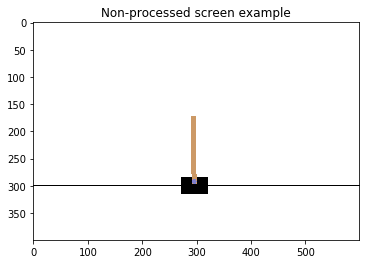

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

## Example of processed screen

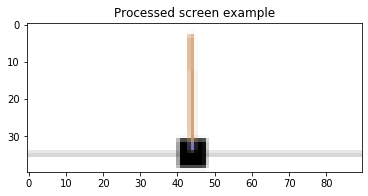

In [10]:
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation ='none')
plt.title('Processed screen example')
plt.show()

#### Example of starting state

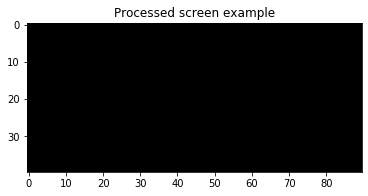

In [11]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()

#### Example of non-starting state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


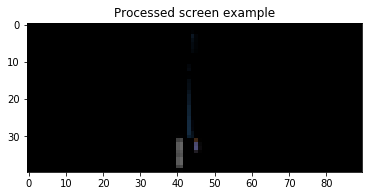

In [12]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen  = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()


#### Example of end state

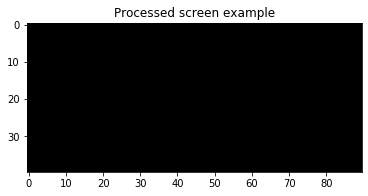

In [13]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()
em.close()

In [14]:
## Utility Functions that will help us during Training

# Utility Functions

## Plotting

In [15]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values),"\n", \
         moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    

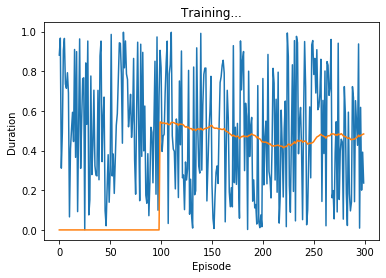

Episode 300 
 100 episode moving avg: 0.48372614


In [16]:
plot(np.random.rand(300),100)

## Tensor Processing

In [17]:
def extract_tensors(experiences):
    ## Accepts a batch of experiences and transposes it into an experience
    ## of batches
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state) # create 'states' tensor
    t2 = torch.cat(batch.action) # create 'actions' tensor
    t3 = torch.cat(batch.reward) # create 'rewards' tensor
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

### Example Of Experience(*zip(*experiences)) used above

See https://stackoverflow.com/a/19343/3343043 for further explanation.

In [18]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1, e2, e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [19]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Q-value Calculator

In [20]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states) \
            .max(dim=1)[0].detach()
        return values

# Main Program

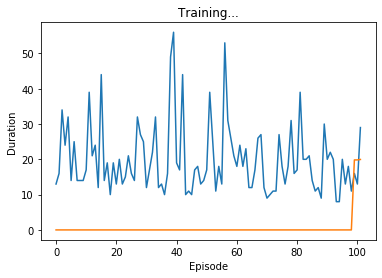

Episode 102 
 100 episode moving avg: 19.96


In [ ]:
## -- HyperParameters --
batch_size = 256
gamma = 0.999
eps_start = 1 ## starting value of exploration rate
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000 ## capacity of replay memory
lr = 0.001 ## Learning Rate
num_episodes = 1000
## -----------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

##---
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
    
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
             
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()
